## 인물 모드 사진 만들기

In [1]:
import os
import urllib # 웹에서 데이터 다운로드
import cv2  # OpenCV라이브러리로 이미지 처리
import numpy as np

from pixellib.semantic import semantic_segmentation #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

### 사진 불러오기

(599, 480, 3)


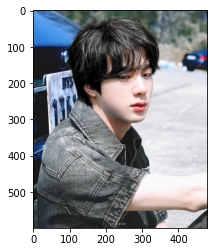

In [2]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/jin_3.jpg'  
img_orig1 = cv2.imread(img_path1) 

print(img_orig1.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

(702, 560, 3)


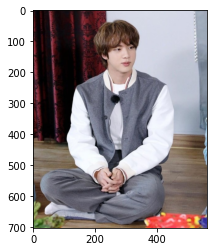

In [3]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/jin_4.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

(225, 225, 3)


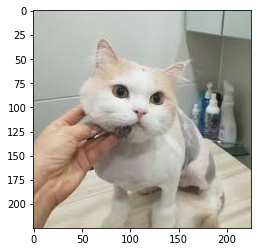

In [4]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_1.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

### PixelLib 

In [5]:
# PixelLib 모델 다운로드

# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f5f838d5a90>)

In [6]:
# 다운로드한 모델을 이용 PixelLib로 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### seg_color 마스크

In [7]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path1)

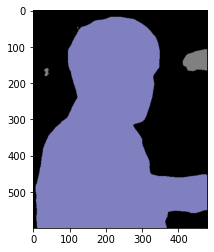

In [8]:
# 모델에서 나온 출력값 확인
plt.imshow(output)
plt.show()

In [9]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [10]:
segvalues

{'class_ids': array([ 0,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

* background, car, person 라벨 확인됨.

In [11]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


In [12]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
# 사람을 나타내는 16번째 색상 확인
colormap[15]

array([192, 128, 128])

In [14]:
# output 이미지가 BGR 순서여서 colormap의 RGB 순서로 바꿔 줌
seg_color = (128,128,192)

(599, 480)


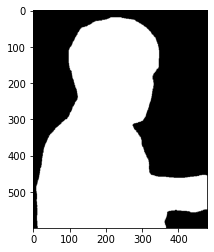

In [15]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

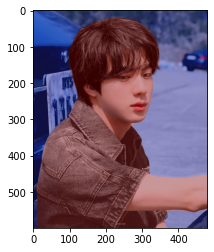

In [16]:
# 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨 - 원래 이미지와 겹쳐 확인

img_show1 = img_orig1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask1 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

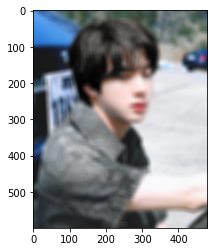

In [17]:
img_orig_blur1 = cv2.blur(img_orig1, (15,15))  # blurring kernel size (15,15)
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))
plt.show()

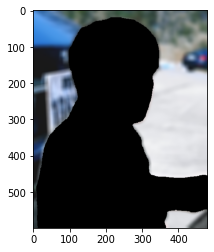

In [18]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color1 = cv2.cvtColor(img_mask1, cv2.COLOR_GRAY2BGR)
img_bg_mask1 = cv2.bitwise_not(img_mask_color1)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

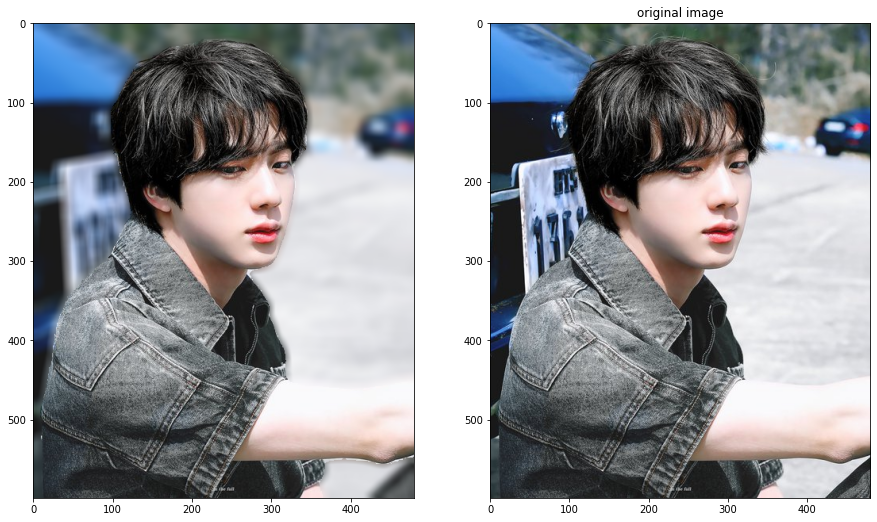

In [19]:
# 흐린 배경과 원본 영상 합성
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.show()

> 블러 처리된 배경과 인물 이미지 경계선이 부자연스럽게 보임.

### 인물 모드 사진 적용 - 두번째

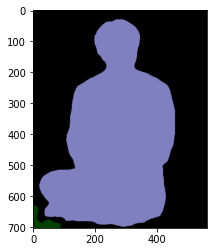

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path2)
plt.imshow(output)
plt.show()

In [21]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


* 배경, 인물, 화분

In [22]:
# 사람을 나타내는 16번째 색상 확인
colormap[15]

array([192, 128, 128])

In [23]:
# output 이미지가 BGR 순서여서 colormap의 RGB 순서로 바꿔 줌
seg_color = (128,128,192)

(702, 560)


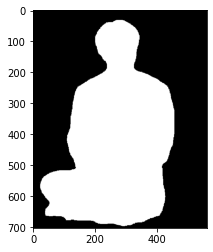

In [24]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

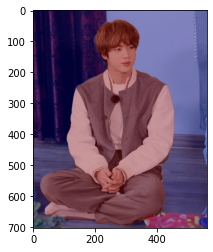

In [25]:
# 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨 - 원래 이미지와 겹쳐 확인

img_show2 = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

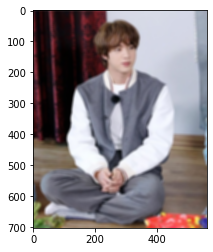

In [26]:
img_orig_blur2 = cv2.blur(img_orig2, (10,10))  # blurring kernel size (10,10)
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

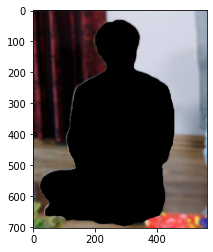

In [27]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

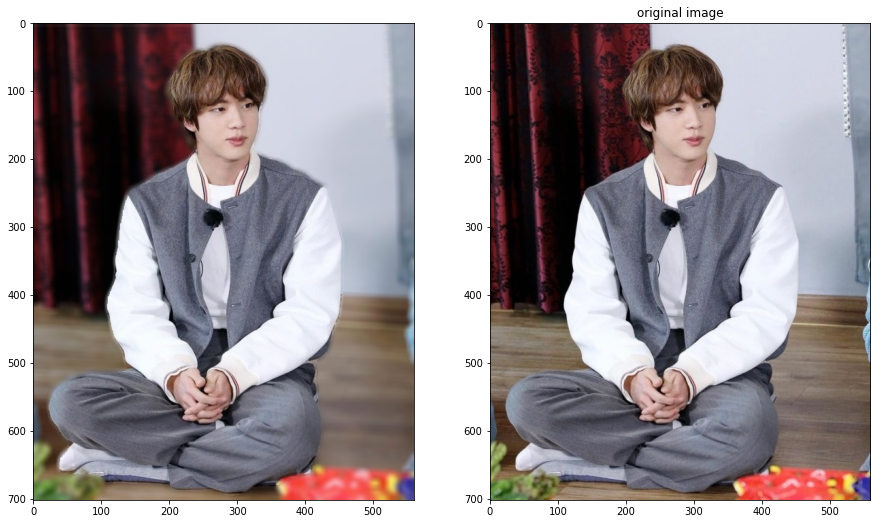

In [28]:
# 흐린 배경과 원본 영상 합성
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.show()

> **blurring kernel size (10,10)를 줄이니 배경과 인물 이미지 경계선이 조금더 자연스럽고 부드럽게 표현 됨.**

### 인물 모드 사진 적용 - 세번째

(225, 225, 3)


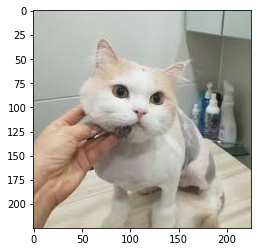

In [29]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_1.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [31]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path3)

In [32]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

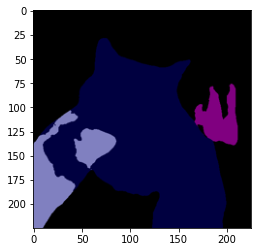

In [33]:
# 모델에서 나온 출력값 확인
plt.imshow(output)
plt.show()

In [34]:
segvalues

{'class_ids': array([ 0,  5,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [35]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
cat
person


In [36]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [37]:
# 고양이를 나타내는 18번째 색상 확인
colormap[8]

array([64,  0,  0])

In [38]:
# output 이미지가 BGR 순서여서 colormap의 RGB 순서로 바꿔 줌
seg_color = (0,0,64)

(225, 225)


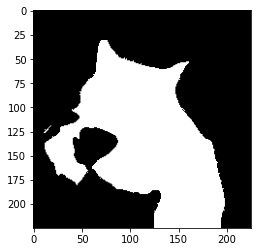

In [39]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

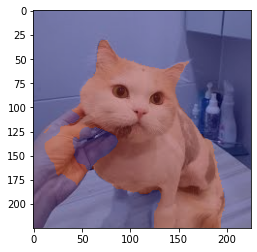

In [40]:
# 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨 - 원래 이미지와 겹쳐 확인

img_show = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

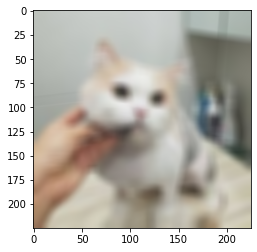

In [41]:
# (10,10)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig3, (10,10))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

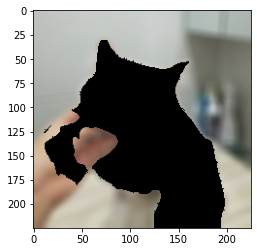

In [42]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

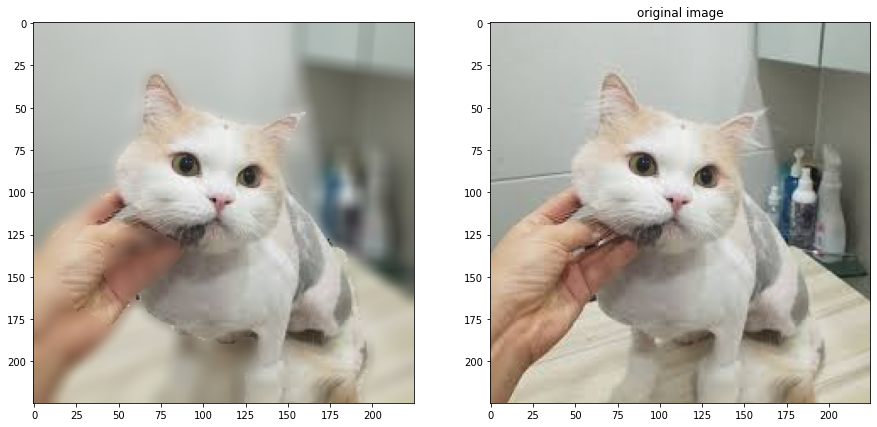

In [43]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.show()

> **고양이와 붙은 손가락 일부가 마스크 영역으로 포함되어 버리고 식탁과 비슷한 색의 고양이 다리는 제외되어 버림.**

### 배경전환 크로마키사진

(702, 560, 3)


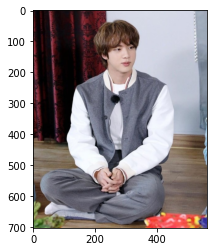

In [62]:
# 합성 이미지
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/jin_4.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

(438, 626, 3)


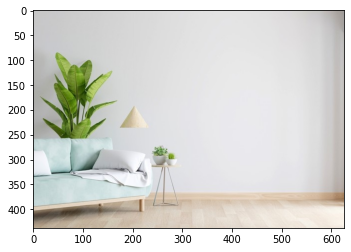

In [63]:
# 배경 이미지 불러오기
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg_image.jpg'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
# 합성 이미지 크기 맞추기
target_size = (img_orig2.shape[1], img_orig2.shape[0])
bg_resized = cv2.resize(img_orig4, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

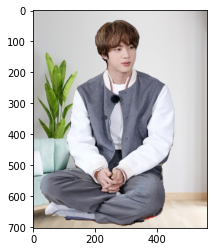

In [72]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR) # 이미 작성되어 있던 seg_color 마스크 사용
img_concat2 = np.where(img_mask_color2==255, img_orig2, bg_resized)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

> **이미지 합성은 되었지만 경계선이 부자연스럽고 크기 조절을 마음대로 할 수 없었음.**<br>
**명예의 전당 김경현님 코딩 참조 했음**

### 후기

><문제점><br>
    * 이미지 경계선이 부자연스럽게 보임.<br>
    * 마스크 영역에 포함되지 않아야 하는 부분 일부 포함과 포함되어야 할 부분이 일부 제외됨.<br>
    * 크로마키사진에서 합성될 사진의 크기나 위치가 마음대로 조절되지 않았음.
    
이미지 경계선의 부자연스러움은 가우시안 블러 사용이나 blurring kernel size 조정등으로 어느정도 개선 가능하다고 함.<br>
크로마키사진에서 이미지 크기를 다른 비율로 시도했으나 실력이 부족해 에러 남.